In [13]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')

%matplotlib inline

## Case study 1: Stochastic volatility

We present a case study of stochastic volatility, time varying stock market volatility, to illustrate PyMC3’s use in addressing a more realistic problem. The distribution of market returns is highly non-normal, which makes sampling the volatilities significantly more difficult. This example has 400+ parameters so using common sampling algorithms like Metropolis-Hastings would get bogged down, generating highly autocorrelated samples. Instead, we use NUTS, which is dramatically more efficient.

## The Model
Asset prices have time-varying volatility (variance of day over day returns). In some periods, returns are highly variable, while in others they are very stable. Stochastic volatility models address this with a latent volatility variable, which changes over time. The following model is similar to the one described in the NUTS paper (Hoffman 2014, p. 21).


$$
\begin{aligned}
\sigma \sim exp(50) \\
\nu \sim exp(0.1)  \\
s_i \sim N(s_i, \sigma^{-2}) \\
log(y_i) \sim t(\nu, 0, exp(-2s_i) \\
\end{aligned}
$$



Here, $y$ is the daily return series which is modeled with a Student-t distribution with an unknown degrees of freedom parameter, and a scale parameter determined by a latent process $s$. The individual $s_i$ are the individual daily log volatilities in the latent log volatility process.

The Data

Our data consist of daily returns of the S&P 500 during the 2008 financial crisis. Here, we use `pandas-datareader` to obtain the price data from Yahoo!-Finance; it can be installed with pip install `pandas-datareader`.

In [2]:
from pandas_datareader import data

In [8]:
returns = data.get_data_yahoo('SPY',  start='2008-05-01', end='2009-12-01')['Close'].pct_change()

In [9]:
len(returns)

402

In [11]:
returns.head()

Date
2008-05-01         NaN
2008-05-02    0.002764
2008-05-05   -0.004805
2008-05-06    0.008663
2008-05-07   -0.017811
Name: Close, dtype: float64

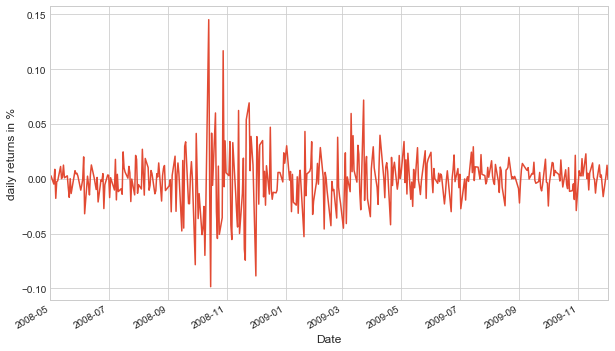

In [25]:
returns.plot(figsize=(10, 6))
plt.ylabel('daily returns in %')

## Model Specification

As with the linear regression example, specifying the model in PyMC3 mirrors its statistical specification. This model employs several new distributions: the Exponential distribution for the $\nu$ and $\sigma$ priors, the Student-T (StudentT) distribution for distribution of returns, and the GaussianRandomWalk for the prior for the latent volatilities.

In PyMC3, variables with purely positive priors like Exponential are transformed with a log transform. This makes sampling more robust. Behind the scenes, a variable in the unconstrained space (named "variableName_log") is added to the model for sampling. In this model this happens behind the scenes for both the degrees of freedom, $\nu$, and the scale parameter for the volatility process, $\sigma$, since they both have exponential priors. Variables with priors that constrain them on two sides, like Beta or Uniform, are also transformed to be unconstrained but with a log odds transform.


Although, unlike model specification in PyMC2, we do not typically provide starting points for variables at the model specification stage, we can also provide an initial value for any distribution (called a "test value") using the `testval` argument. This overrides the default test value for the distribution (usually the mean, median or mode of the distribution), and is most often useful if some values are illegal and we want to ensure we select a legal one. The test values for the distributions are also used as a starting point for sampling and optimization by default, though this is easily overriden.

The vector of latent volatilities $s$ is given a prior distribution by GaussianRandomWalk. As its name suggests GaussianRandomWalk is a vector valued distribution where the values of the vector form a random normal walk of length n, as specified by the shape argument. The scale of the innovations of the random walk, sigma, is specified in terms of the precision of the normally distributed innovations and can be a scalar or vector.



In [26]:
with pm.Model() as sp500_model:
    nu = pm.Exponential('nu', 1./10, testval=5.)
    sigma = pm.Exponential('sigma', 1./.02, testval=.1)

    s = pm.GaussianRandomWalk('s', sigma**-2, shape=len(returns))
    volatility_process = pm.Deterministic('volatility_process', pm.math.exp(-2*s))

    r = pm.StudentT('r', nu, lam=1/volatility_process, observed=returns)

Notice that we transform the log volatility process s into the volatility process by `pm.math.exp(-2*s)`. Here, exp is a Theano function, rather than the corresponding function in NumPy; Theano provides a large subset of the mathematical functions that NumPy does.

Also note that we have declared the Model name sp500_model in the first occurrence of the context manager, rather than splitting it into two lines, as we did for the first example.

In [27]:
with sp500_model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 885.35: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [00:57<00:00, 3503.42it/s]
Finished [100%]: Average ELBO = 885.16
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:15<00:00, 11.52it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000119E9828>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000001011B5C0>]], dtype=object)

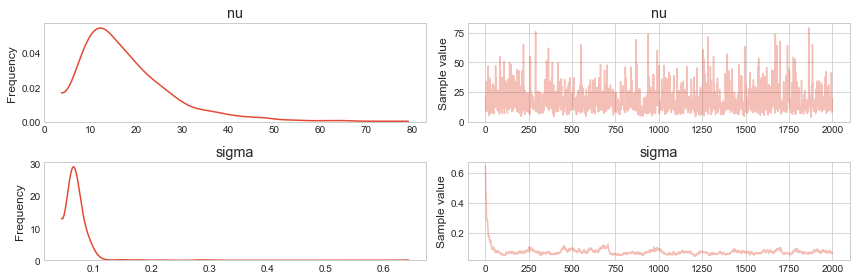

In [28]:
## We can check our samples by looking at the traceplot for nu and sigma

pm.traceplot(trace, [nu, sigma])

Finally we plot the distribution of volatility paths by plotting many of our sampled volatility paths on the same graph. Each is rendered partially transparent (via the `alpha` argument in Matplotlib’s `plot` function) so the regions where many paths overlap are shaded more darkly.

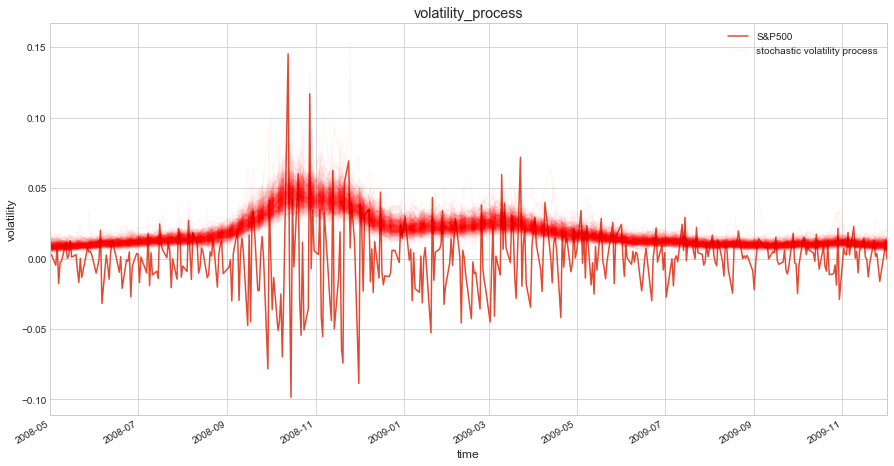

In [29]:
fig, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax)
ax.plot(returns.index, 1/np.exp(trace['s',::5].T), 'r', alpha=.03);
ax.set(title='volatility_process', xlabel='time', ylabel='volatility');
ax.legend(['S&P500', 'stochastic volatility process'])

As you can see, the model correctly infers the increase in volatility during the 2008 financial crash. Moreover, note that this model is quite complex because of its high dimensionality and dependency-structure in the random walk distribution. NUTS as implemented in PyMC3, however, correctly infers the posterior distribution with ease.